In [1]:
import os
import numpy as np
import pickle
from matplotlib import pyplot as plt

fig_width = 4

swept_args = ['rec_loss_fn', 'lbd_opt_kwargs', 'separate_cls_partition']

In [2]:
results_dir = os.path.join('.', 'results', 'lagrangian_trial')
trial_dirs = [
    f for f in os.listdir(results_dir)
    if os.path.isdir(os.path.join(results_dir, f))
    and not '.' in f
    and f != 'pretrained_models'
]

def get_results(mode='final'):
    results = {**{arg: [] for arg in swept_args}, 'rec_loss': [], 'indcls_acc': []}
    if mode == 'final':
        for trial_dir in trial_dirs:
            for suffix in ['trial_info.pickle', os.path.join('validation', 'epoch_250.pickle'), os.path.join('validation', 'epoch_300.pickle')]:
                with open(os.path.join(results_dir, trial_dir, 'results', suffix), 'rb') as F:
                    trial_results = pickle.load(F)
                    for key, item in trial_results.items():
                        if key in results.keys():
                            results[key].append(item)
    elif mode == 'best':
        best_rec_loss = np.inf
        for trial_dir in trial_dirs:
            with open(os.path.join(results_dir, trial_dir, 'results', 'trial_info.pickle'), 'rb') as F:
                trial_info = pickle.load(F)
                for key, item in trial_info.items():
                    if key in results.keys():
                        results[key].extend(2*[item])
            for epoch_file in os.listdir(os.path.join(results_dir, trial_dir, 'results', 'validation')):
                if not epoch_file.split('.')[-1] == 'pickle':
                    continue
                with open(os.path.join(results_dir, trial_dir, 'results', 'validation', epoch_file), 'rb') as F:
                    epoch_results = pickle.load(F)
                if not 'rec_loss' in epoch_results.keys():
                    continue
                if epoch_results['rec_loss'] < best_rec_loss:
                    best_rec_loss = epoch_results['rec_loss']
            results['rec_loss'].append(best_rec_loss)
            with open(os.path.join(results_dir, trial_dir, 'results', 'validation', 'epoch_300.pickle'), 'rb') as F:
                epoch_results = pickle.load(F)
            results['indcls_acc'].append(epoch_results['indcls_acc'])
    else:
        assert False
        
    return results

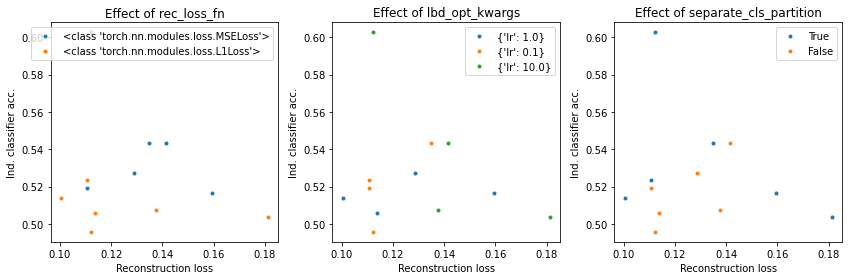

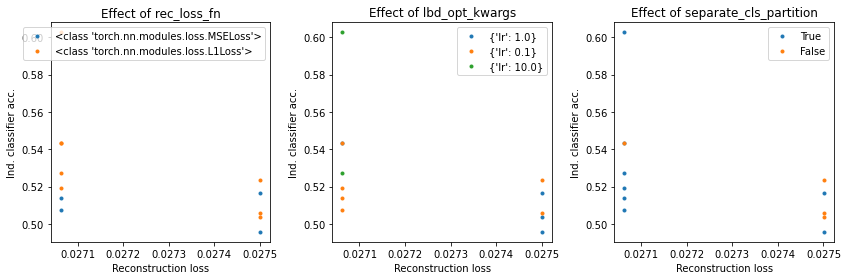

In [3]:
def get_traces_for_hparam(results, hparam):
    traces = {}
    for hval, rec_loss, indcls_acc in zip(results[hparam], results['rec_loss'], results['indcls_acc']):
        hval = str(hval)
        if not hval in traces.keys():
            traces[hval] = {'rec_loss': [], 'indcls_acc': []}
        traces[hval]['rec_loss'].append(rec_loss)
        traces[hval]['indcls_acc'].append(indcls_acc)
    return traces

def plot_gridsearch(mode='final'):
    results = get_results(mode=mode)
    fig, axes = plt.subplots(1, len(swept_args), figsize=(fig_width*len(swept_args), fig_width))
    for ax, hparam in zip(axes.flatten(), swept_args):
        traces_dict = get_traces_for_hparam(results, hparam)
        for hval, traces in traces_dict.items():
            ax.plot(traces['rec_loss'], traces['indcls_acc'], '.', label=str(hval))
        ax.set_xlabel('Reconstruction loss')
        ax.set_ylabel('Ind. classifier acc.')
        ax.set_title('Effect of {}'.format(hparam))
        ax.legend()
    plt.tight_layout()

for mode in ['final', 'best']:
    plot_gridsearch(mode=mode)